In [1]:
import numpy as np
import scipy.special
import scipy.stats
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def norm_gamm(x, t):
    a = 1.
    b = 1.
    lambd = 1.
    mu = 0.
    const = b ** a * np.sqrt(lambd) / (scipy.special.gamma(a) * np.sqrt(2. * np.pi))
    oth = t ** (a - 0.5) * np.exp( - b * t)
    norm = np.exp(- lambd * t / 2. * (x - mu)**2.)
    return const * oth * norm

def norm_gamm_neal(x, t):
    """
    in terms of the notation of the function norm_gamm:
    a = a_neal / 2
    b = a_neal / (2 * w_neal)
    lambd_neal = 1
    """
    a = 0.2
    w = 100
    mu = 0.
    const = (a / (2. * w))**(a / 2.) / (scipy.special.gamma(a / 2.) * np.sqrt(2. * np.pi))
    oth = t ** (a / 2. - 1.) * np.exp(- t * a / (2. * w))
    norm = t ** (1. / 2.) * np.exp(- t / 2. * (x - mu)**2.)
    return const * oth * norm

def unit_norm_norm(x, t):
    return np.exp(- 1. / 2. * (x)**2.) * np.exp(- 1. / 2. * (t)**2.)

def gamma(t):
    a = 0.2 / 2.
    b = a / 100.
    return b ** a / scipy.special.gamma(a) * t ** (a - 1.) * np.exp(- b * t)

def gamma_neal(t):
    a = 0.2
    w = 100.
    return (a / (2. * w)) ** (a / 2.) / scipy.special.gamma(a / 2.) * t ** (a / 2. - 1.) * np.exp(- a / (2. * w) * t)

def gamma_scipy(t):
    """
    parameters are as in gamma(t) function
    """
    a = 0.2 / 2
    b = a / 100.
    rv = scipy.stats.gamma(a = a, scale = 1. / b)
    return rv.pdf(t)

/home/astrophysics/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in power
/home/astrophysics/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


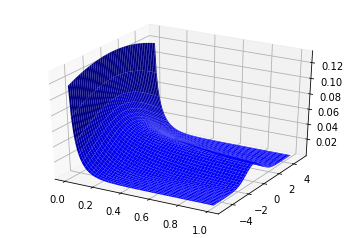

In [12]:
x = np.linspace(-5, 5, 100)
t = np.linspace(0, 1, 100)
xx, tt = np.meshgrid(x, t, indexing='ij')
z = norm_gamm_neal(xx, tt)
fig = plt.figure('3d')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(tt, xx, z, color='b')

/home/astrophysics/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in power
/home/astrophysics/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in power


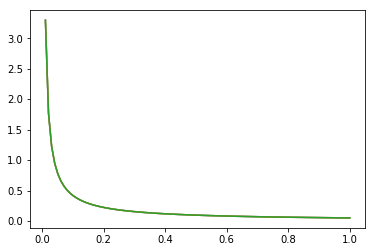

In [41]:
plt.figure('2d')
plt.plot(t, gamma(t))
plt.plot(t, gamma_neal(t))
plt.plot(t, gamma_scipy(t))